<!-- <div align='center' ><font color = blue size='8' face = '黑体'>黄河口悬浮泥沙分布在线反演APP</font></div>
<div align='right' ><font color = green size='2' face = '黑体'>------by xiaoming</font></div>
<div align='left' ><font size='5' face = '楷体'> 
    1.通过云量筛选指定日期黄河口的影像<br>
    2.利用内置的悬沙反演算法将选择的影像执行反演程序，显示反演结果<br><br><br>
    界面加载速度受网络影响，请等候.......
    </font></div>                                                                       -->

<div align='center' ><font color = #66CCCC size='7' face = '楷体' ><b>黄河口悬浮泥沙分布在线反演APP</b></font></div>

**可实现:**
<font size='5' face = '楷体'> 
1. 通过云量筛选指定日期黄河口的影像
2. 利用内置的悬沙反演算法将选择的影像执行反演程序，显示反演结果 
3. 制图输出


<br><br>
**Contact： Xiaoming**  (https://suxiaoming.tech/) 


<br>
界面加载速度受网络影响，请稍等......

In [2]:
import os
# os.environ["HTTP_PROXY"]="http://127.0.0.1:4780"
# os.environ["HTTPS_PROXY"]="http://127.0.0.1:4780"

import ee
import geemap
import ipywidgets as widgets
from bqplot import pyplot as plt
from ipyleaflet import WidgetControl
from ipywidgets import AppLayout, Button, Layout, Textarea, Combobox,ButtonStyle
import matplotlib.pyplot as plt
from geemap import cartoee
from matplotlib.lines import Line2D

In [3]:
Map = geemap.Map(center=[37.7,118.8],zoom=9)
Map

Map(center=[37.7, 118.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

In [4]:
# 添加卫星影像数据，卫星影像按照云量进行筛选的函数
def cloud_select(year,cloud):
    if 1984<= year <=2011:
        start_y = ee.Date.fromYMD(year,1,1)
        end_y = start_y.advance(1,'year')
        images = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR')\
              .filterDate(start_y,end_y)\
              .filter(ee.Filter.eq('WRS_ROW',34))\
              .filter(ee.Filter.eq('WRS_PATH',121))\
              .filter(ee.Filter.lte('CLOUD_COVER',cloud))

        sys_id = images.aggregate_array('system:id').getInfo()
        cloud = images.aggregate_array('CLOUD_COVER').getInfo()
        # 显示影响的序列号加上云量
        result = []
        for i in range(len(sys_id)):
            result.append(sys_id[i] + ' : '+ str(cloud[i]))
        return result,sys_id
    elif 2012 <= year <= 2014:
        
        start_y = ee.Date.fromYMD(year,1,1)
        end_y = start_y.advance(1,'year')
        images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')\
              .filterDate(start_y,end_y)\
              .filter(ee.Filter.eq('WRS_ROW',34))\
              .filter(ee.Filter.eq('WRS_PATH',121))\
              .filter(ee.Filter.lte('CLOUD_COVER',cloud))

        sys_id = images.aggregate_array('system:id').getInfo()
        cloud = images.aggregate_array('CLOUD_COVER').getInfo()
        # 显示影响的序列号加上云量
        result = []
        for i in range(len(sys_id)):
            result.append(sys_id[i] + ' : '+ str(cloud[i]))
        return result,sys_id
    else:
        start_y = ee.Date.fromYMD(year,1,1)
        end_y = start_y.advance(1,'year')
        images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')\
              .filterDate(start_y,end_y)\
              .filter(ee.Filter.eq('WRS_ROW',34))\
              .filter(ee.Filter.eq('WRS_PATH',121))\
              .filter(ee.Filter.lte('CLOUD_COVER',cloud))

        sys_id = images.aggregate_array('system:id').getInfo()
        cloud = images.aggregate_array('CLOUD_COVER').getInfo()
        # 显示影响的序列号加上云量
        result = []
        for i in range(len(sys_id)):
            result.append(sys_id[i] + ' : '+ str(cloud[i]))
        return result,sys_id

In [5]:
# Landsat 7去条带
def func_lvr(image):
  filled1a = image.focal_mean(2, 'square', 'pixels', 1)
  return filled1a.blend(image) 

In [6]:
# 反演SSC
def l5_ssc(image):
    sssc = image.expression(
        '1603.194 * (x*x*x) - 2677.011 * (x*x) + 2569.904 * x -368.906',{
            'x': image.select('B4').divide(image.select('B1'))
        }
    )
    return sssc

def l7_ssc(image):
    sssc = image.expression(
        '1502.239 * (x*x*x) - 2529.413 * (x*x) + 2490.969 * x -358.319',{
            'x': image.select('B4').divide(image.select('B1'))
        }
    )
    return sssc

def l8_ssc(image):
    sssc = image.expression(
        '1406.405 * (x*x*x) - 1824.106 * (x*x) + 2323.982 * x -268.034',{
            'x': image.select('B5').divide(image.select('B2'))
        }
    )
    return sssc

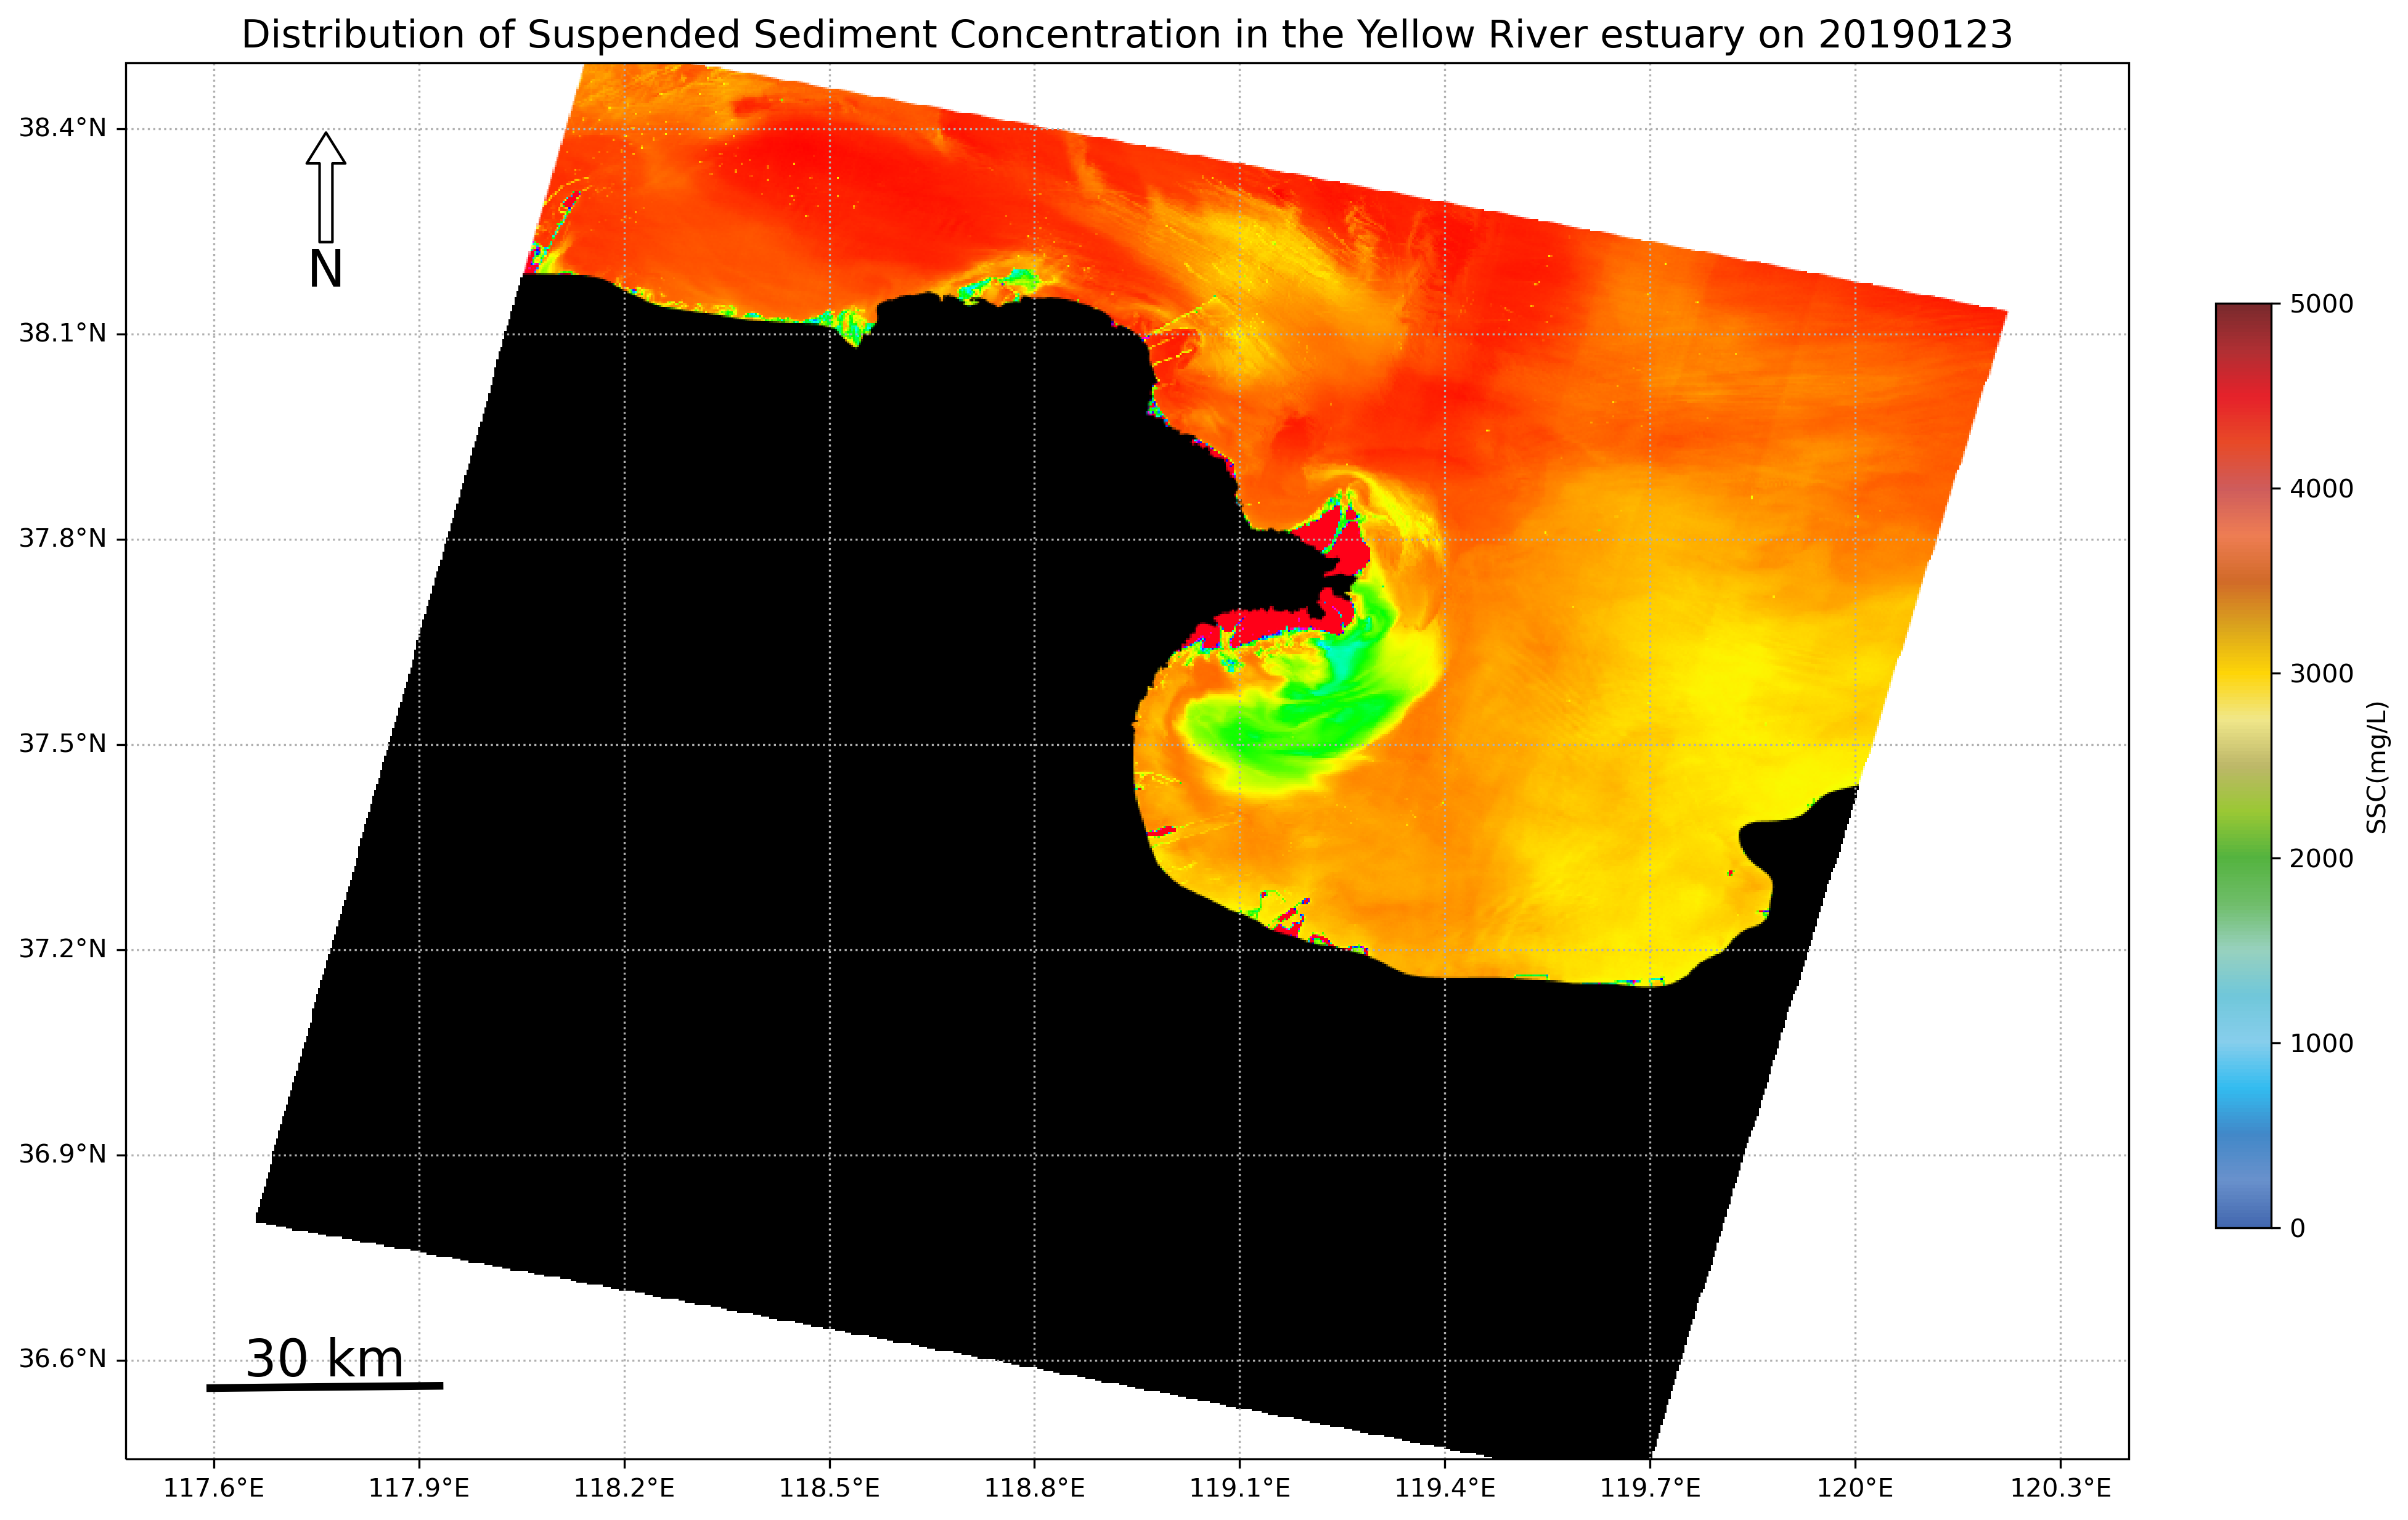

In [7]:
# 界面设计搭建
style = {'description_width':'initial'}

# 在地图右下角增加一个框用于显示文字或者图表
output_widget = widgets.Output(layout={'border':'1px solid black'})
output_control = WidgetControl(widget = output_widget,position = 'bottomright')
Map.add_control(output_control)

# 小部件
image_select = widgets.Dropdown(
    description = '选择数据源：',
    options=['Landsat','MODIS'],
    value = 'Landsat',
    style = style
)

time_slider = widgets.IntSlider(
    value = 1984,
    min = 1984,
    max = 2020,
    step = 1,
    description = '年份',
    orientation = 'horizontal',
    style = style
)

cloud_slider = widgets.FloatSlider(
    value = 10,
    min = 0,
    max = 20,
    step = 0.1,
    description = '云量',
    orientation = 'horizontal',
    style = style,
    readout_format = '.1f'
)

static_btn = widgets.Button(
    description = '按云量筛选',
    button_style = 'primary',
    tooltip = '单击',
    style = style
)

result_ta = Textarea(description='结果（eg. id : cloud_cover）', layout=Layout(width='600px', height='150px'),style = style)
image_cb = Combobox(description='选择影像', layout=Layout(width='600px', height='auto'),style = style)
image_btn = Button(description='显示影像', layout=Layout(width='auto',height='auto') ,button_style='info')
ssc_btn = Button(description='反演SSC', layout=Layout(width='auto',height='auto') ,style=ButtonStyle(button_color='#FED154'))
plot_btn = Button(description='制图', layout=Layout(width='auto',height='auto'), style=ButtonStyle(button_color='#88EA79'))
zero_btn = Button(description='软件初始化', layout=Layout(width='auto',height='auto'), style=ButtonStyle(button_color='#E69494'))

# 布局
full_widget = widgets.VBox([
    widgets.HBox([image_select,time_slider,cloud_slider,static_btn]),
    widgets.HBox([result_ta]),
    widgets.HBox([image_cb, image_btn,ssc_btn, plot_btn]),
    widgets.HBox([zero_btn])
])

full_widget

In [8]:
# 点击事件
# 云量筛选
def submit_clicked(a):
    
    with output_widget:
        output_widget.clear_output()
        print('请稍等，正在查找中.......')
        Map.default_style = {'cursor': 'wait'}
    
        try:
            image = image_select.value
            year = time_slider.value
            cloud = cloud_slider.value
            output_widget.clear_output()
            if image == 'Landsat':
                result,sys_id = cloud_select(year,cloud)
                result_ta.value = str(result)
                image_cb.options = sys_id
        except Exception as e:
            print(e)
            print('查找过程出现错误，请重新输入参数！')
        Map.default_style = {'cursor': 'default'}


# 显示影像
def show_image(b):
    with output_widget:
        output_widget.clear_output()
        try:
            id = image_cb.value
            image = ee.Image(id)
#             判断是不是L7影像，进行去条带操作
            if id[11] == '7':
                image = func_lvr(image)
            
            vis_params = {
                'bands':['B4','B3','B2'],
                'min': 0,
                'max': 3000
            }
            Map.addLayer(image,vis_params,'select image')
            
        except Exception as e:
            print(e)
            print('加载失败')
            
# 显示SSC
def show_ssc(c):
    with output_widget:
        output_widget.clear_output()
        try:
            id = image_cb.value
            image = ee.Image(id)
            #判断是不是L7影像，进行去条带操作
            if id[11] == '7':
                image = func_lvr(image)
                
            landshp = ee.FeatureCollection('users/bluesky666/yrd_1984')
            oceanshp = ee.FeatureCollection('users/bluesky666/yrd_1984sea')
            # 利用陆地和海洋shp分别裁剪出陆地和海洋范围
            land = image.clip(landshp)
            ocean = image.clip(oceanshp)

            # Set visualization parameters.
            vis_params0 = {'bands': ['B1'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}
            vis_params = {'bands': ['constant'], 'palette': ['ff0000', ' ff0600', ' ff0c00', ' ff1200', ' ff1800', ' ff1e00', ' ff2300', ' ff2900', ' ff2f00', ' ff3500', ' ff3b00', ' ff4100', ' ff4700', ' ff4d00', ' ff5300', ' ff5900', ' ff5f00', ' ff6400', ' ff6a00', ' ff7000', ' ff7600', ' ff7c00', ' ff8200', ' ff8800', ' ff8e00', ' ff9400', ' ff9a00', ' ff9f00', ' ffa500', ' ffab00', ' ffb100', ' ffb700', ' ffbd00', ' ffc300', ' ffc900', ' ffcf00', ' ffd500', ' ffdb00', ' ffe000', ' ffe600', ' ffec00', ' fef100', ' fcf500', ' faf900', ' f8fd00', ' f4ff00', ' eeff00', ' e8ff00', ' e2ff00', ' ddff00', ' d7ff00', ' d1ff00', ' cbff00', ' c5ff00', ' bfff00', ' b9ff00', ' b3ff00', ' adff00', ' a7ff00', ' a2ff00', ' 9cff00', ' 96ff00', ' 90ff00', ' 8aff00', ' 84ff00', ' 7eff00', ' 78ff00', ' 72ff00', ' 6cff00', ' 66ff00', ' 61ff00', ' 5bff00', ' 55ff00', ' 4fff00', ' 49ff00', ' 43ff00', ' 3dff00', ' 37ff00', ' 31ff00', ' 2bff00', ' 25ff00', ' 20ff00', ' 1aff00', ' 14ff00', ' 0eff00', ' 08ff00', ' 06ff04', ' 04ff08', ' 02ff0c', ' 00ff10', ' 00ff16', ' 00ff1b', ' 00ff21', ' 00ff27', ' 00ff2d', ' 00ff33', ' 00ff39', ' 00ff3f', ' 00ff45', ' 00ff4b', ' 00ff51', ' 00ff57', ' 00ff5c', ' 00ff62', ' 00ff68', ' 00ff6e', ' 00ff74', ' 00ff7a', ' 00ff80', ' 00ff86', ' 00ff8c', ' 00ff92', ' 00ff97', ' 00ff9d', ' 00ffa3', ' 00ffa9', ' 00ffaf', ' 00ffb5', ' 00ffbb', ' 00ffc1', ' 00ffc7', ' 00ffcd', ' 00ffd3', ' 00ffd8', ' 00ffde', ' 00ffe4', ' 00ffea', ' 00fff0', ' 00fff6', ' 00fffc', ' 00fcff', ' 00f6ff', ' 00f0ff', ' 00eaff', ' 00e5ff', ' 00dfff', ' 00d9ff', ' 00d3ff', ' 00cdff', ' 00c7ff', ' 00c1ff', ' 00bbff', ' 00b5ff', ' 00afff', ' 00aaff', ' 00a4ff', ' 009eff', ' 0098ff', ' 0092ff', ' 008cff', ' 0086ff', ' 0080ff', ' 007aff', ' 0074ff', ' 006eff', ' 0069ff', ' 0063ff', ' 005dff', ' 0057ff', ' 0051ff', ' 004bff', ' 0045ff', ' 003fff', ' 0039ff', ' 0033ff', ' 002dff', ' 0028ff', ' 0022ff', ' 001cff', ' 0016ff', ' 0010ff', ' 020cff', ' 0408ff', ' 0604ff', ' 0800ff', ' 0e00ff', ' 1300ff', ' 1900ff', ' 1f00ff', ' 2500ff', ' 2b00ff', ' 3100ff', ' 3700ff', ' 3d00ff', ' 4300ff', ' 4900ff', ' 4f00ff', ' 5400ff', ' 5a00ff', ' 6000ff', ' 6600ff', ' 6c00ff', ' 7200ff', ' 7800ff', ' 7e00ff', ' 8400ff', ' 8a00ff', ' 9000ff', ' 9500ff', ' 9b00ff', ' a100ff', ' a700ff', ' ad00ff', ' b300ff', ' b900ff', ' bf00ff', ' c500ff', ' cb00ff', ' d000ff', ' d600ff', ' dc00ff', ' e200ff', ' e800ff', ' ee00ff', ' f400ff', ' f800fd', ' fa00f9', ' fc00f5', ' fe00f1', ' ff00ed', ' ff00e7', ' ff00e1', ' ff00db', ' ff00d5', ' ff00cf', ' ff00c9', ' ff00c3', ' ff00bd', ' ff00b7', ' ff00b1', ' ff00ac', ' ff00a6', ' ff00a0', ' ff009a', ' ff0094', ' ff008e', ' ff0088', ' ff0082', ' ff007c', ' ff0076', ' ff0071', ' ff006b', ' ff0065', ' ff005f', ' ff0059', ' ff0053', ' ff004d', ' ff0047', ' ff0041', ' ff003b', ' ff0035', ' ff0030', ' ff002a', ' ff0024', ' ff001e', ' ff0018'], 'min': 0.0, 'max': 3000.0, 'opacity': 1.0}


            #判断是哪个传感器，用不同的反演公式
            if id[11] == '5':
                ssc = l5_ssc(ocean).visualize(**vis_params)
            
            elif id[11] == '7':
                ssc = l7_ssc(ocean).visualize(**vis_params)
            
            elif id[11] == '8':
                ssc = l8_ssc(ocean).visualize(**vis_params)
            
            Map.addLayer(ssc,{},'ssc')
            
            # 将陆地设置为0，方便显示
            land = land.where(land,0)
            land = land.visualize(**vis_params0)
            Map.addLayer(land,{},'land')
            
            #为了便于成图陆地海洋合并成一张图             
            global blend 
            blend = land.blend(ssc)
            Map.addLayer(blend,{},'blend')
            
        except Exception as e:
            print(e)
            print('加载失败')
            
# 制图
def plt_show(d):
    fig = plt.figure(figsize=(15, 10),dpi = 300)

    # here is the bounding box of the map extent we want to use
    # formatted a [W,S,E,N]
    zoom_region = [117.4714, 36.4558, 120.4, 38.4966]

    # plot the map over the region of interest
    vis = {}
    ax = cartoee.get_map(blend, vis_params=vis, region=zoom_region)

    # add the gridlines and specify that the xtick labels be rotated 45 degrees
    cartoee.add_gridlines(ax, interval=0.3, xtick_rotation=0, linestyle=":")

    # add coastline
    # ax.coastlines(color="cyan")

    # add a colorbar to the map using the visualization params we passed to the map
    vis_params_zq = {'palette': ['4368AF', '6991CC', '4188C8', '33BCF0', '87CEEC', '70C7DA', '98D1BE', '6FBD69', '54B33F', '9AC834', 'BDB769', 'F0E78A', 'FED507', 'DAA41D', 'D16A28', 'EE7D53', 'CE5C5C', 'E84A27', 'E6212A', 'B02F33', '792A2D'], 'min': 0.0, 'max': 5000.0, 'opacity': 1.0}
    cartoee.add_colorbar(ax, vis_params_zq, loc="right", label = "SSC(mg/L)",orientation="vertical")

    # add north arrow
    cartoee.add_north_arrow(ax, text="N", xy=(0.1, 0.95), text_color="black", arrow_color="white", fontsize=20)

    # add scale bar
    cartoee.add_scale_bar_lite(ax, length=30, xy=(0.1, 0.05), fontsize=20, color="black", unit="km")

    ax.set_title(label = "Distribution of Suspended Sediment Concentration in the Yellow River estuary on "+ image_cb.value[-8:] , fontsize=15)

    # add legend
    # legend_elements = [Line2D([], [], color='#00ffff', lw=2, label='Coastline'),
    #     Line2D([], [], marker='o', color='#A8321D', label='City', markerfacecolor='#A8321D', markersize=10, ls ='')]

    # cartoee.add_legend(ax, legend_elements, loc='lower right')

    plt.show()
    
# 地图初始化
def map_zero(e):
    Map.clear_layers()
    Map.add_basemap('Google Maps')
            
# 增加点击事件
static_btn.on_click(submit_clicked)
image_btn.on_click(show_image)
ssc_btn.on_click(show_ssc)
plot_btn.on_click(plt_show)
zero_btn.on_click(map_zero)